## Import

In [2]:
import torch.nn as nn
import torch
import numpy as np
from tqdm.notebook import tqdm as tqdm_n
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from copy import copy, deepcopy
from tqdm.notebook import tqdm, trange

# import ray


In [3]:
import torch

In [4]:
%load_ext autoreload
%autoreload 2

## Data

### Datasets

In [8]:
from community.data.datasets.generate import get_datasets_symbols, get_datasets_alphabet
from community.utils.plotting import plot_grid, create_gifs
from community.data.tasks import get_task_target, get_factors_list
from community.utils.configs import configure_readouts
from community.utils.others import nested_shape, nested_len
from community.common.models.ensembles import Community


In [9]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 512

In [212]:
use_symbols = False

n_agents = 2
n_classes_per_digit = 8
n_classes = n_classes_per_digit * n_agents

data_config = {
    "batch_size": 256,
    "data_sizes": None,  # np.array([30000, 5000]) ,
    "input_size": 28,
    "common_input": False,
    "use_cuda": use_cuda,
    "fix_asym": False,
    "permute_dataset": True,
    "seed": np.random.randint(100),
    "data_type": "symbols" if use_symbols else 'double_d',
    'n_digits' : n_agents,
    "n_classes": n_classes,
    "n_classes_per_digit": n_classes_per_digit,
    "symbol_config": {},
    "split_classes": True,
    'nb_steps' : 3
}

if use_symbols:

    symbol_config = {
        "data_sizes": np.array([60000, 10000]) // 2 ,
        "nb_steps": data_config['nb_steps'],
        "n_symbols": n_classes - 1,
        "symbol_type": "mod_5",
        "input_size": 60,
        "static": True,
        "n_diff_symbols": n_agents,
        "parallel": False,
        "adjust_probas": False,
        'random_transform' : True
    }

    if symbol_config["static"]:
        #symbol_config["nb_steps"] = 10
        symbol_config["data_size"] = [d for d in symbol_config["data_sizes"]]

    n_bits = np.ceil(np.log2(n_classes)).astype(int)

    data_config["symbol_config"] = symbol_config
    data_config["input_size"] = symbol_config["input_size"]
    data_config["data_type"] = "symbols"
    # loaders, datasets = get_datasets_symbols(data_config, batch_size, use_cuda, plot=True)

In [216]:
if use_symbols:
    loaders, datasets = get_datasets_symbols(
        data_config, batch_size, use_cuda, plot=True
    )
else:

    all_loaders = get_datasets_alphabet("../../data/", data_config)
    loaders = all_loaders[
        ["multi", "double_d", "double_l", "single_d" "single_l"].index(
            data_config["data_type"]
        )
    ]
    
    datasets = [l.dataset for l in loaders]

### Plot / stats

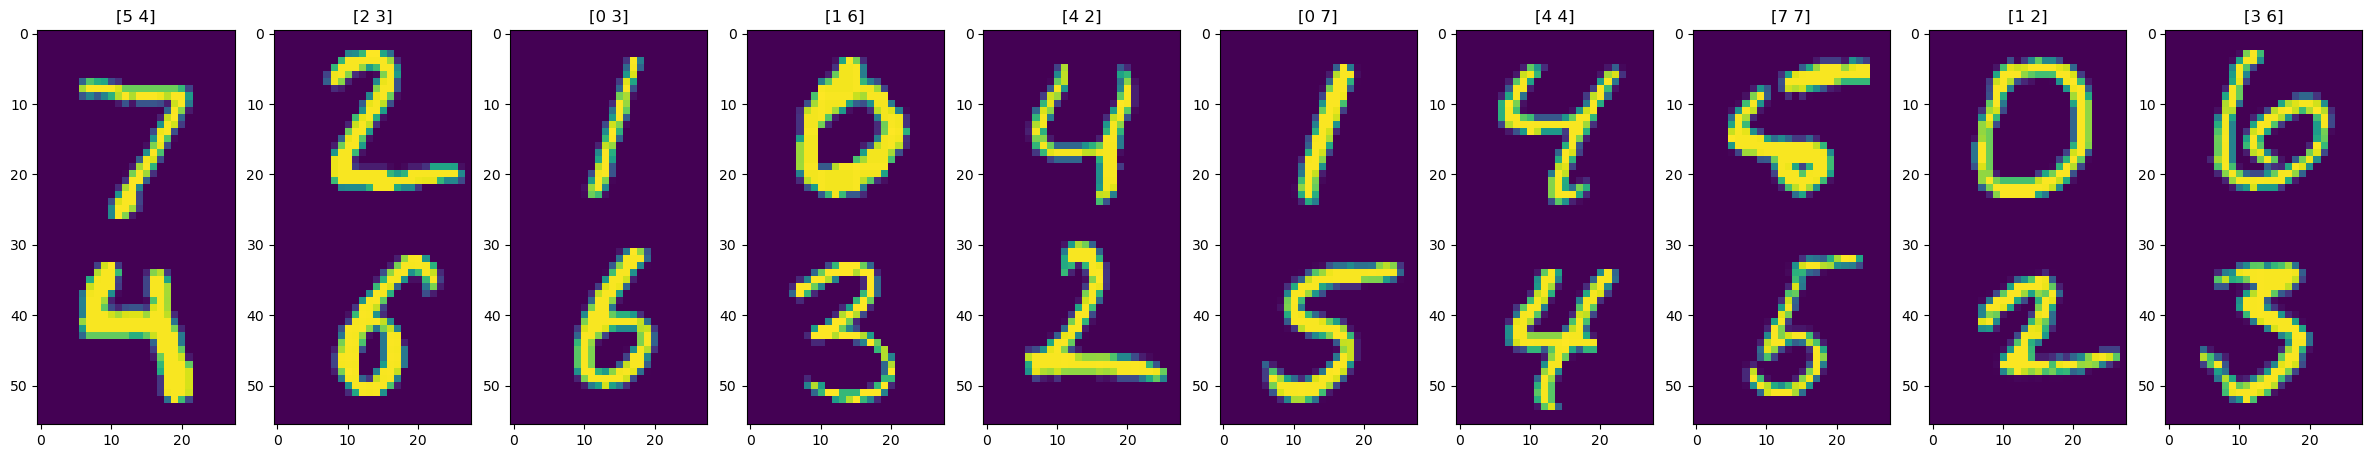

In [217]:
if use_symbols:
    data, targets = datasets[0].data[:-1]
    s = 50
    fig, axs = plt.subplots(1, 5, figsize=(30, 20))
    for i, ax in enumerate(axs):
        if not data_config["common_input"]:
            ax.imshow(data[i + s][-1].reshape(120, 60))
            ax.set_title(targets[i + s].data.numpy())
        else:
            ax.imshow(data[i + s][-1].reshape(60, 60))
            ax.set_title(targets[i + s].data.numpy())
else:
    s = 0
    data, targets = next(iter(loaders[1]))
    fig, axs = plt.subplots(1, 10, figsize=(30, 20))
    for i, ax in enumerate(axs):
        if data_config["data_type"] in ["double_d", "double_l", "multi"]:
            ax.imshow(data[i + s].reshape(2 * 28, 28))
            ax.set_title(targets[i + s].data.numpy())
        else:
            ax.imshow(data[i + s].reshape(28, 28))
            ax.set_title(targets[i + s].data.numpy())

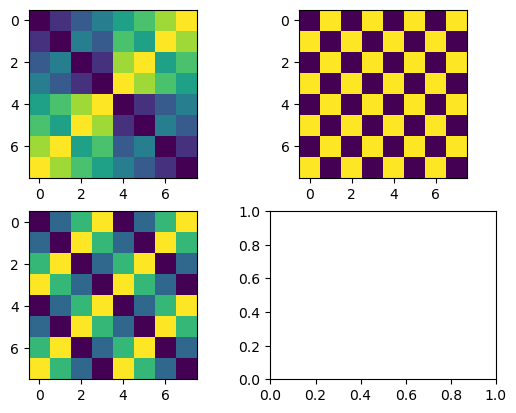

In [ ]:
from itertools import product
pairs = torch.tensor(list(product(torch.arange(n_classes_per_digit), repeat=2)), dtype=int)
fig, axs = plt.subplots(2, 2)
n_bits = int(np.log2(n_classes_per_digit))
for task, ax in zip(['bitxor'] + [f"bitxor-last-{i}" for i in range(1, n_bits)], axs.flatten()) : 
    xor = get_task_target(pairs, task, n_classes_per_digit).reshape(n_classes_per_digit, n_classes_per_digit)
    ax.imshow(xor)

In [218]:
all_targets = datasets[0].data[1]
print(all_targets.unique(return_counts=True))
task = "bitxor"
t_targets = get_task_target(all_targets, task, n_classes_per_digit)
print(t_targets.unique(return_counts=True))
print([(t_targets == t).sum() for t in all_targets.T])

(tensor([0, 1, 2, 3, 4, 5, 6, 7]), tensor([11846, 13484, 11916, 12262, 11684, 10842, 11836, 12530]))
(tensor([0, 1, 2, 3, 4, 5, 6, 7]), tensor([6036, 6030, 5968, 6028, 5965, 6021, 6135, 6017]))
[tensor(5923), tensor(5923)]


In [11]:
if False:

    task = "parity-equal"

    uniques, unique_counts = all_targets.unique(dim=0, return_counts=True)
    task_t = get_task_target(all_targets, task, n_classes_per_digit)
    task_t.unique(dim=0, return_counts=True), (all_targets[:, 0] == task_t).unique(
        dim=0, return_counts=True
    ), (all_targets[:, 1] == task_t).unique(dim=0, return_counts=True)
    digits_in = lambda d1, d2: (torch.tensor([d1, d2]) == uniques).all(1).any()
    digits_idx = (
        lambda d1, d2: (torch.tensor([d1, d2]) == uniques).all(1).float().argmax()
    )
    counts = np.zeros((n_classes_per_digit + 1, n_classes_per_digit + 1))
    targets = np.zeros((n_classes_per_digit + 1, n_classes_per_digit + 1), dtype=object)

    for d1 in range(n_classes_per_digit):
        counts[d1, -1] = (
            (all_targets[:, 0] == task_t)[all_targets[:, 0] == d1]
        ).sum()  # unique_counts[(uniques == d1)[:, 0]].sum()
        targets[d1, -1] = str(counts[d1, -1])
        for d2 in range(n_classes_per_digit):
            if digits_in(d1, d2):
                counts[d1, d2] = unique_counts[digits_idx(d1, d2)]
                targets[
                    d1, d2
                ] = f"{get_task_target(uniques, task, n_classes_per_digit)[digits_idx(d1, d2)].cpu().data.item()} | {unique_counts[digits_idx(d1, d2)]}"
            else:
                counts[d1, d2] = -0.1
                targets[d1, d2] = "X"
            counts[-1, d2] = (
                (all_targets[:, 1] == task_t)[all_targets[:, 1] == d2]
            ).sum()  # unique_counts[(uniques == d2)[:, 1]].sum()
            targets[-1, d2] = str(counts[-1, d2])

    counts[-1, -1] = unique_counts.sum().cpu().data.item()
    targets[-1, -1] = str(
        f"D0 : {(all_targets[:, 0] == task_t).unique(dim=0, return_counts=True)[1][1]} \n"
        + f"D1 : {(all_targets[:, 1] == task_t).unique(dim=0, return_counts=True)[1][1]}"
    )

    plt.figure(figsize=(10, 10), dpi=100)
    ax = sns.heatmap(
        counts, cmap="inferno", annot=targets, annot_kws={"fontsize": 8}, fmt="s"
    )
    ax.set_title("Number of examples and global targets")

    ax.set_xlabel("Digit received by Agent 1")
    ax.set_ylabel("Digit received by Agent 0")
    ax.set_xticklabels([str(i) for i in range(n_classes_per_digit)] + ["dig=global"])
    ax.set_yticklabels([str(i) for i in range(n_classes_per_digit)] + ["dig=global"])

    plt.show()

## Init

In [219]:
from community.funcspec.single_model_loop import (
    init_and_train,
    train_and_compute_metrics,
    train_community,
    init_community,
    init_optimizers,
)
from community.common.models.ensembles import Community
from community.data.process import process_data
from community.utils.configs import get_training_dict,configure_readouts, configure_single_readout
import yaml
from yaml.loader import SafeLoader

with open("../../latest_config.yml", "r") as config_file:
    config = yaml.load(config_file, SafeLoader)

try shared goals with sum

Implement a task str-parsing function

In [220]:
with open("../../latest_config.yml", "r") as config_file:
    config = yaml.load(config_file, SafeLoader)

# task = config["task"] = [ str(i) for i in range(n_agents)]  # "family"  # [[str(i), str((i+1)%3)] for i in range(3)]
# task = config["task"] = [['0', '1'], ['1', '2'], ['0', '2']] #"both"

config["datasets"] = data_config

#task = config["task"] = ["bitxor", 'bitxor-last-2', 'bitxor-last-1', 'bitxor-first-2', 'bitxor-first-1']
#task =  config["task"] = ['parity', '0', '1']
task = config['task'] = 'all'

config["model"]["agents"]["n_in"] = data_config["input_size"] ** 2 * (
    1 + data_config["common_input"] * (1 - use_symbols)
)

n_hidden = config["model"]["agents"]["n_hidden"] = 10
config["model"]["agents"]["n_bot"] = 5

config["model"]["n_agents"] = n_agents

common_readout = config["model"]['readout']["common_readout"] = False
config["model"]['readout']["n_hid"] = 30
config['model']['readout']['readout_from'] = None 

readout_config = configure_readouts(config)
config['model']['readout'].update(readout_config)

sparsity = config["model"]["connections"]["sparsity"] = 0 / n_hidden**2  # .005
config["model"]["connections"]["comms_out_scale"] = 1
config["model"]["connections"]["comms_start"] = "start"
config["model"]["connections"]["binarize"] = False


decision = config["training"]["decision"] = [
    "last",
    "both" if common_readout else "both",
]

n_epochs = config["training"]["n_epochs"] = 15

print(
    f'Training {n_agents} agents of size {n_hidden} on task {task} using {"common"*common_readout + "separate"*(1-common_readout)} readout and decision {decision}, with {sparsity * n_hidden**2} connections and { config["model"]["readout"]["n_out"] } outputs'
)

Training 2 agents of size 10 on task all using separate readout and decision ['last', 'both'], with 0.0 connections and [8, 8] outputs


In [221]:
#config['model']['agents']['n_readouts'] = 3

In [226]:
community = init_community(config["model"], device=device)

reg_readout = 0

if not reg_readout:
    optimizer = torch.optim.Adam(community.parameters(), lr=1e-3)

else:
    optimizer = torch.optim.AdamW(
        [p for n, p in community.named_parameters() if "readout" not in n], lr=1e-3
    )
    optimizer.add_param_group(
        {
            "params": [p for n, p in community.named_parameters() if "readout" in n],
            "lr": 1e-3,
            "weight_decay": reg_readout,
        }
    )

config["use_tqdm"] = True
community.nb_connections


{}

In [228]:
for n, p in community.named_parameters() : 
    if 'agents.0' in n : 
        p.requires_grad = False

In [229]:
data, target = next(iter(loaders[0]))
data, target = process_data(
    data,
    target,
    symbols=use_symbols,
    task=task,
    n_steps=3,
    common_input=config["datasets"]["common_input"],
)
data, target = data.to(device), target.to(device)

out, states, ag_outs, fconns = community(data)

try : 
    print(out.shape, fconns.shape)
except AttributeError : 
    print(nested_shape(out))
#print(data.shape)

torch.Size([3, 2, 2, 256, 8]) torch.Size([2, 3])


## Training

In [230]:
model_load = False
model_save = True

n_epochs = 10
community.to(device)

def train(
    community=community, optimizers=[optimizer, None], n_epochs=n_epochs, test=False
):
    return train_community(
        community,
        *loaders,
        optimizers=optimizers,
        config=get_training_dict(config),
        n_epochs=n_epochs if not test else 1,
        trials=(not test, True),
        show_all_acc=True,
        use_tqdm=not test,
        device=device
    )
try:
    saved_results = torch.load("saves/results")
    train_results = saved_results[str(config)]

    if model_load:
        community.load_state_dict(train_results["best_state"])
    else:
        train_results = train()

    if model_save:
        saved_results[str(config)] = train_results
        torch.save(saved_results, "saves/results")

except FileNotFoundError:
    # config["task"] = [str(i) for i in range(n_agents)]

    train_results = train()

    if model_save:
        saved_results = {}
        saved_results[str(config)] = train_results
        torch.save(saved_results, "saves/resuls")

except (KeyError, RuntimeError) as e:
    train_results = train()
    saved_results[str(config)] = train_results
    if model_save:
        torch.save(saved_results, "saves/results")

testing_acc = train(test=True)["test_accs"]
print(f"Test Acc : {testing_acc}")

Train Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [211]:
community.agents[0].readout

ModuleList(
  (0-1): 2 x Sequential(
    (0): Linear(in_features=5, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=8, bias=True)
  )
)

In [1]:
plt.plot(train_results["test_accs"]);

NameError: name 'plt' is not defined

In [19]:
raise StopIteration

StopIteration: 

In [ ]:
testing_acc = train(test=True)["test_accs"]
testing_acc

## Binary representations 

In [161]:
import torch.nn.functional as F
def binary_conn(target):
    encoding = [[] for _ in range(2)]
    for ag in range(2) : 
        encoded_target = target[:, ag].clone().detach()
        for d in range(n_bits - 1, -1, -1):
            encoding[ag].append(torch.div(encoded_target, 2**d, rounding_mode="floor"))
            encoded_target -= (
                torch.div(encoded_target, 2**d, rounding_mode="floor") * 2**d
            )
    return torch.stack([torch.stack(e, -1) for e in encoding])

### Minimal model

In [191]:
task = '0'

n_epochs = 10
if 'last' in task : 
    n_last = int(task.split('-')[-1])
    n_out = 2 ** n_last
else : 
    n_out = n_classes_per_digit

n_out = 2*n_classes_per_digit

n_in = 5

minimal_model = nn.Sequential(nn.Linear(n_in, 30), nn.ReLU(), nn.Linear(30, n_out))
#minimal_model = nn.Linear(n_in, n_out)
optim = torch.optim.Adam(minimal_model.parameters(), lr=1e-2)

In [192]:
minimal_input = torch.cat([ago[-1] for ago in ag_outs], -1)
minimal_input.shape

torch.Size([256, 15])

In [193]:
community.to('cpu')
pbar_e = tqdm(range(n_epochs), position=0, leave=None, desc='Epochs ')
desc = np.array(['', ''], dtype=object)
for e in pbar_e : 

    for b, (data, target) in enumerate(loaders[0]): 
        
        data, target = process_data(
            data,
            target,
            symbols=use_symbols,
            task=task,
            n_steps=10,
            common_input=config["datasets"]["common_input"],
        )

        #minimal_input = torch.cat([*binary_conn(target)], -1).float()
        #minimal_input = torch.cat([minimal_input, torch.rand_like(minimal_input)], -1)
        out, states, ag_outs, fconns = community(data)
        #minimal_input = torch.cat([ago[-1] for ago in ag_outs], -1).squeeze()
        minimal_input = ag_outs[-1][1 - int(task)]
        
        minimal_output = minimal_model(minimal_input)
        t_target = get_task_target(target, task, n_classes=n_classes_per_digit)

        loss = F.cross_entropy(minimal_output, t_target, reduction="mean")
        optim.zero_grad()
        loss.backward()
        optim.step()

        pred = minimal_output.argmax(dim=-1)
        correct = pred.eq(t_target.view_as(pred))
        acc = (
            (correct.sum(-1) * np.prod(t_target.shape[:-1]) / t_target.numel())
            .cpu()
            .data.numpy()
        )

        desc[0] = f'Epochs : {b}/{len(loaders[0])}, Acc = {acc:.2f}, Loss = {loss:.2f}'
        pbar_e.set_description(desc.sum(0))

    for b, (data, target) in enumerate(loaders[1]): 
        
        data, target = process_data(
            data,
            target,
            symbols=use_symbols,
            task=task,
            n_steps=10,
            common_input=config["datasets"]["common_input"],
        )

        #minimal_input = torch.cat([*binary_conn(target)], -1).float()
        #minimal_input = torch.cat([minimal_input, torch.rand_like(minimal_input)], -1)
        out, states, ag_outs, fconns = community(data)
        minimal_input = torch.cat([ago[-1] for ago in ag_outs], -1).squeeze()
        minimal_input = ag_outs[-1][1 - int(task)]
        
        minimal_output = minimal_model(minimal_input)
        t_target = get_task_target(target, task, n_classes=n_classes_per_digit)

        loss = F.cross_entropy(minimal_output, t_target, reduction="mean")
        pred = minimal_output.argmax(dim=-1)
        correct = pred.eq(t_target.view_as(pred))
        acc = (
            (correct.sum(-1) * np.prod(t_target.shape[:-1]) / t_target.numel())
            .cpu()
            .data.numpy()
        )

        desc[1] = f'| Test :  Acc = {acc:.2f}, Loss = {loss:.2f}'
        pbar_e.set_description(desc.sum(0))

Epochs :   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
minimal_input.shape

torch.Size([1, 256, 10])

## Retraining : 

### Readout Only

In [ ]:
task = config["task"] = "parity-digits"
config["model"]["readout_n_hid"] = 2

configure_readouts(config)


community.n_readouts = config["model"]["n_readouts"]


community.initialize_readout(
    config["model"]["n_readouts"],
    config["model"]["readout_from"],
    config["model"]["readout_n_hid"] = 2
)
                    
community.to(device)

config["training"]["n_epochs"] = 20
# config["task"] = [str(i) for i in range(n_agents)]

optimizer = torch.optim.Adam(
        [p for n, p in community.named_parameters() if "readout" in n],
        lr=1e-3,
    )


In [ ]:
train_results = train_community(
    community,
    *loaders,
    optimizers=[optimizer, None],
    config=get_training_dict(config),
    show_all_acc=True,
    use_tqdm=True,
)

Train Epoch::   0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

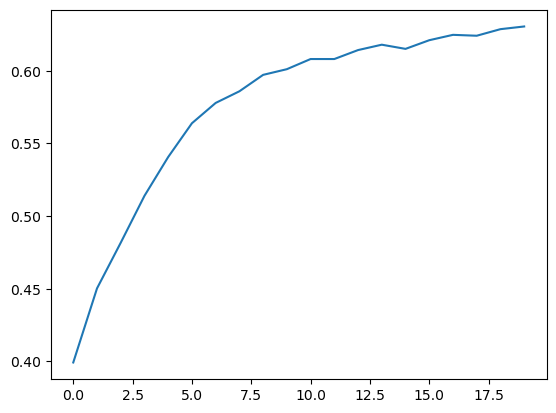

In [ ]:
plt.plot(train_results["test_accs"])


In [ ]:
config["model"]


{'agents': {'ag_dropout': 0.0,
  'cell_type': "<class 'torch.nn.modules.rnn.RNN'>",
  'n_hidden': 50,
  'n_in': 3600,
  'n_layers': 1,
  'n_out': 10,
  'n_readouts': None,
  'train_in_out': [True, True],
  'use_bottleneck': False},
 'common_readout': True,
 'connections': {'binarize': True,
  'comms_dropout': 0.0,
  'comms_start': 'start',
  'sparsity': 0.8,
  'use_deepR': False},
 'n_agents': 2,
 'n_ins': None,
 'n_readouts': 1,
 'readout_from': None}

In [ ]:
plt.plot(train_results["test_accs"])

In [ ]:
freeze_retrain = True

task = config["task"] = "inv_parity-digits"
# task = config["task"] = 'both'
# task = config["task"] = [["0", "1"], ["1", "2"], ["0", "2"]]
# task = config["task"] = ["0", "1", "max", "min"]

config["model"]["n_agents"] = 2
config["model"]["agents"]["n_hidden"] = 10
common_readout = config["model"]["common_readout"] = True

configure_readouts(config)

if not freeze_retrain:

    community = init_community(config["model"])

community.n_readouts = config["model"]["n_readouts"]
config["model"]["readout_n_hid"] = 10
config["model"]["connections"]["sparsity"] = 0.0
community.use_common_readout = True

for ag in community.agents:
    ag.dims[-1] = n_classes

community.initialize_readout(
    config["model"]["n_readouts"],
    config["model"]["readout_from"],
    config["model"]["readout_n_hid"],
)

community.to(device)

reg_readout = 1

if freeze_retrain:

    optimizer = torch.optim.AdamW(
        [p for n, p in community.named_parameters() if "readout" in n],
        lr=1e-3,
        weight_decay=reg_readout,
    )

else:
    if not reg_readout:
        optimizer = torch.optim.Adam(community.parameters(), lr=1e-3)
    else:
        optimizer = torch.optim.AdamW(
            [
                p
                for n, p in community.named_parameters()
                if n not in ["readout.0", "readout.1"]
            ],
            lr=1e-3,
        )
        optimizer.add_param_group(
            {
                "params": [
                    p
                    for n, p in community.named_parameters()
                    if n in ["readout.0", "readout.1"]
                ],
                "lr": 1e-3,
                "weight_decay": reg_readout,
            }
        )

data, target = next(iter(loaders[1]))
data, target = process_data(data, target, symbols=True, task=task)
data, target = data.to(device), target.to(device)

out, states, fconns = community(data)

print(out.shape)


In [ ]:
class New_community(nn.Module):
    def __init__(self, community, task="family") -> None:
        super().__init__()
        self.community = community
        self.connections = {}

        if task == "family":
            self.dim_out = [len(get_factors_list(n_agents)), n_classes]
        elif isinstance(task, list):
            self.dim_out = [len(task), n_classes]
        else:
            self.dim_out = [2, n_classes_per_digit]

        self.readout = nn.Linear(20, np.prod(self.dim_out))

    def forward(self, x, conns=0):
        out, states, conns = self.community(x)
        new_out = self.readout(torch.cat([o for o in out[-1]], -1))
        new_out = new_out.reshape(-1, *self.dim_out).transpose(0, 1).unsqueeze(0)

        return new_out, states, conns

In [ ]:
task = config["task"] = "both"
task = config["task"] = ["0", "1", "bitand", "bitor", "max", "min"]

community = init_community(config["model"])


new_com = New_community(community, task).to(device)
new_com.is_community = True


optimizer = torch.optim.AdamW(
    [
        p
        for n, p in new_com.named_parameters()
        if n in ["readout.weight", "readout.bias"]
    ],
    lr=1e-3,
    weight_decay=reg_readout,
)

optimizer = torch.optim.Adam(new_com.parameters(), lr=1e-3)

In [ ]:
data, target = next(iter(loaders[1]))
data, target = process_data(data, target, symbols=True, task=task)
data, target = data.to(device), target.to(device)

new_com(data)[0].shape

In [ ]:
config["training"]["n_epochs"] = 10

train_results = train_community(
    community,
    *loaders,
    optimizers=[optimizer, None],
    config=get_training_dict(config),
    show_all_acc=True,
    use_tqdm=True
)

In [ ]:
if task == "family":
    label = [str(t.data.numpy()) for t in get_factors_list(n_agents)]
elif isinstance(task, list):
    label = task
elif task in ["both", "all"]:
    labem = ["0", "1"]
else:
    label = None
plt.plot(train_results["test_accs"], label=label)
plt.legend()
plt.show()

## Analysis


### PCA on agent outs

In [167]:
def binary_conn(target):
    encoding = [[] for _ in range(2)]
    for ag in range(2) : 
        encoded_target = target[:, ag].clone().detach()
        for d in range(n_bits - 1, -1, -1):
            encoding[ag].append(torch.div(encoded_target, 2**d, rounding_mode="floor"))
            encoded_target -= (
                torch.div(encoded_target, 2**d, rounding_mode="floor") * 2**d
            )
    return torch.stack([torch.stack(e, -1) for e in encoding])

In [168]:
data, target = next(iter(loaders[0]))
data, target = process_data(
    data,
    target,
    symbols=use_symbols,
    task=task,
    n_steps=config['datasets']['nb_steps'],
    common_input=config["datasets"]["common_input"],
)
data, target = data.to(device), target.to(device)

out, states, ag_outs, fconns = community(data)


In [169]:
from sklearn.decomposition import PCA 


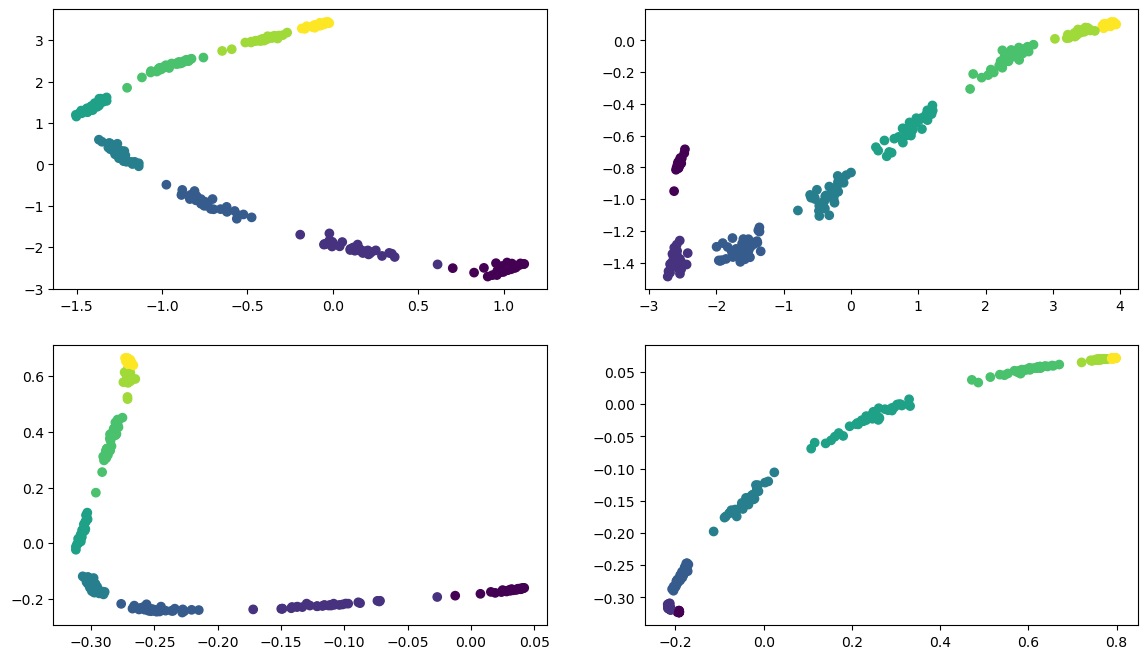

In [189]:
ag_out = [torch.cat([*ag_outs[-1]], 0).squeeze(), torch.cat([*ag_outs[-1]], 0).softmax(-1).squeeze()]


fig, axs = plt.subplots(2, 2, figsize=(14, 8))
for i, axs_soft in enumerate(axs) : 
    pca = PCA(2)
    pca_out = pca.fit_transform(ag_out[i].cpu().data.numpy())
    for ag, ax in enumerate(axs_soft) : 
        ax.scatter(*pca_out[256*ag:256*(ag + 1)].T, c=target[:, ag])


In [186]:
ag_out[0].shape

torch.Size([256, 10])

In [176]:
pca_out.shape

(256, 2)

In [174]:
ag_out.shape

torch.Size([2, 256, 5])

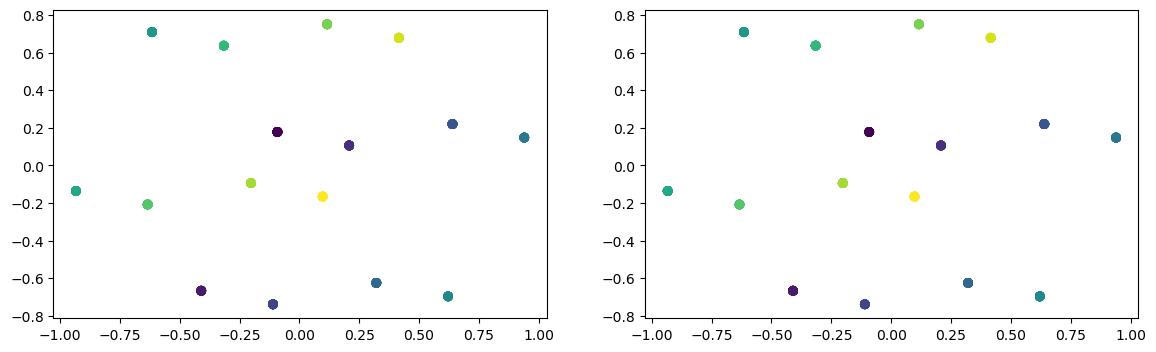

In [ ]:
pca = PCA(2)
binary_target = torch.cat([*binary_conn(target)], 0)
pca_out = pca.fit_transform(binary_target.cpu().data.numpy())
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

for ag, ax in enumerate(axs) : 
    ax.scatter(*pca_out[256*ag:256*(ag + 1)].T, c=target[:, ag])


### Readouts

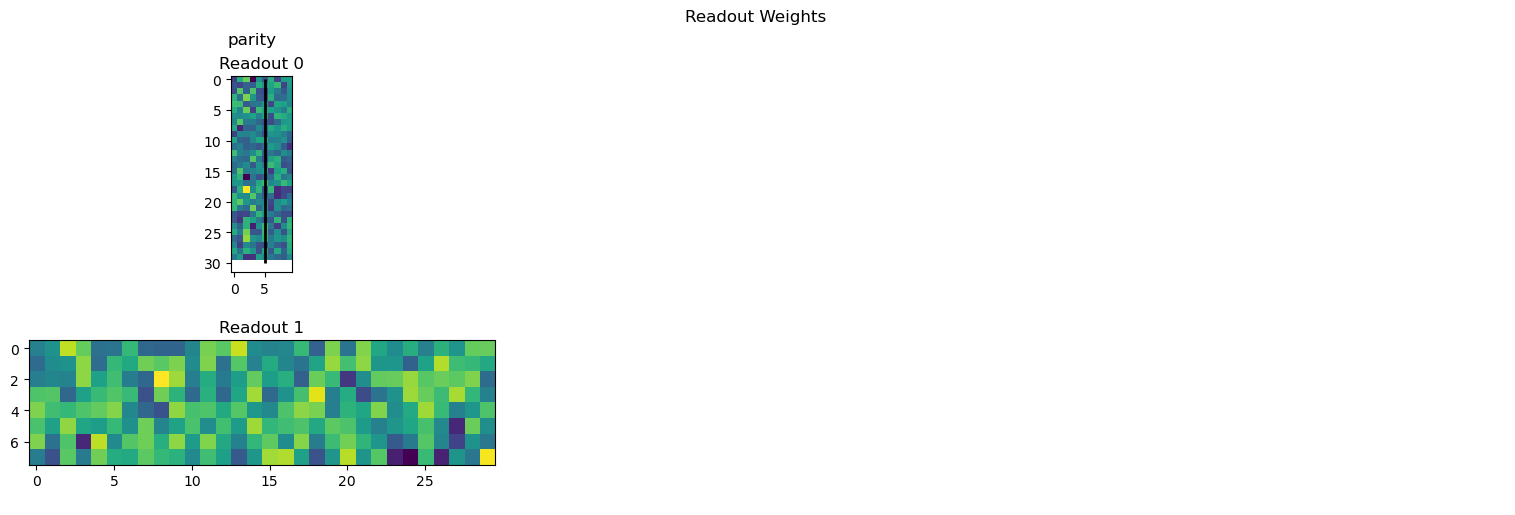

In [42]:
if task == "family":
    task_f = [t.data.numpy() for t in get_factors_list(data_config["n_diff_symbols"])]
elif isinstance(task, list):
    task_f = task
else:
    if "both" in task:
        task_f = [0, 1]
    else:
        task_f = [task]

fig = plt.figure(constrained_layout=True, figsize=(5 * len(community.readout), 5))
fig.suptitle("Readout Weights")

# create 3x1 subfigs
subfigs = fig.subfigures(1, len(community.readout))
if len(community.readout) == 1:
    subfigs = [subfigs]

for readout, subfig, t in zip(community.readout, subfigs, task_f):

    subfig.suptitle(t)

    if hasattr(readout, "__len__"):

        if hasattr(readout[0], "__len__"):
            axs = subfig.subplots(len(readout[0]) - 1, len(readout))
            for ax_r, r in zip(axs, readout):
                l = 0
                for layer in r:
                    if hasattr(layer, "weight"):
                        ax = ax_r[l]
                        w = layer.weight.cpu().data.numpy()
                        ax.imshow(w)
                        ax.set_title(f"Layer {l}")
                        l += 1
        else:
            axs = subfig.subplots(
                len(readout) - 1 * isinstance(readout, nn.Sequential), 1
            )
            if not hasattr(axs, "__len__"):
                axs = [axs]
            layer = 0
            for r in readout:
                if hasattr(r, "weight"):
                    ax = axs[layer]
                    w = r.weight.cpu().data.numpy()
                    ax.imshow(w)
                    if layer == 0:
                        ax.vlines(
                            [w.shape[1] // 2],
                            -0.01,
                            w.shape[0],
                            color="black",
                            linewidth=2,
                        )
                    ax.set_title(f"Readout {layer}")
                    layer += 1

    else:
        ax = subfig.subplots(1, 1)
        w = readout.weight.cpu().data.numpy()
        ax.vlines([w.shape[1] // 2], -0.01, w.shape[0], color="black", linewidth=2)
        ax.imshow(w)
        ax.set_title(f"{w.mean() :.4E}")

### Global rec Matrix + Com matric

In [43]:
w_rec_global = community.w_rec_global.data
plt.imshow(w_rec_global)

KeyError: '01'

In [ ]:
abs_w = w_rec_global.abs()
stepI = abs_w.sum(1)
stepII = torch.pow(stepI, -0.5)
stepIII = torch.diag(stepII)
stepIV = torch.matrix_exp(stepIII @ abs_w @ stepIII)
stepIV[torch.eye(abs_w.shape[0], dtype=bool)] = 0

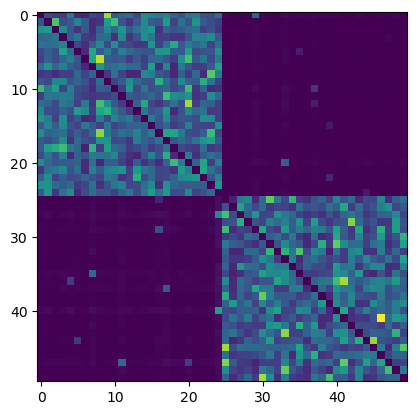

In [ ]:
plt.imshow(stepIV.data.cpu())

## Metrics

### Retraining

In [203]:
from community.funcspec.bottleneck import readout_retrain

steps = [str(community.min_t_comms -1 ), "last"]
community.to(device)

bottleneck_metrics, f_community = readout_retrain(
    community,
    loaders,
    config,
    n_epochs=1,
    use_tqdm=True,
    chosen_timesteps=steps,
    n_hid=30,
    task='all',
    device=device
)


Bottleneck Metric Trials :   0%|          | 0/2 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/1 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
det = lambda M: np.abs(np.linalg.det(M))

def plot_metric(metric):

    n_steps = len(metric)
    fig, axs = plt.subplots(1, n_steps, figsize=(10, 3), constrained_layout=True)

    if n_steps == 1:
        axs = [axs]

    for s, ax in enumerate(axs):

        im = ax.imshow(metric[s])

        ax.set_ylabel("agents")
        ax.set_xlabel("Task")

        ax.set_xticks(range(len(metric[s])))
        ax.set_yticks(range(len(metric[s])))

        fig.colorbar(im, ax=ax)

        ax.set_title(
            f"Det = {det(metric[s]) :.3E} \n Normed Det = {det(metric[s]) / metric[s].sum(0).prod() :.3E}"
        )

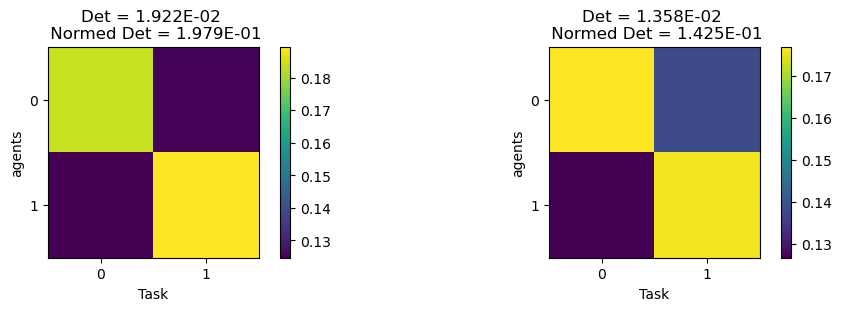

In [ ]:
plot_metric(np.stack([bottleneck_metrics["accs"][:, :, s] for s in range(len(steps))]))

### Return of the masks

In [ ]:
from community.funcspec.masks import (
    train_and_get_mask_metric,
    Mask_Community,
    get_proportions,
    get_proportions_per_agent,
    GetSubnet_global,
    find_optimal_sparsity,
    train_mask,
)


In [ ]:
mask_metrics, masked_coms = train_and_get_mask_metric(
    community,
    0.2,
    loaders,
    config,
    n_epochs=1,
    lr=1e-1,
    use_optimal_sparsity=False,
    device=torch.device("cuda"),
    use_tqdm=True,
    chosen_timesteps=["last"],
)

Mask Metric Trials :   0%|          | 0/1 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/1 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
masked_coms[0][1].proportions.sum()


0.23553719

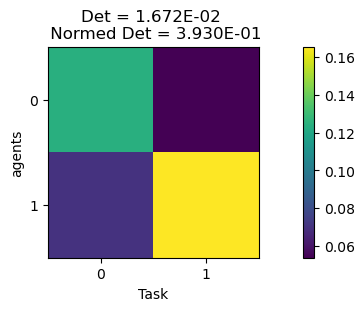

In [ ]:
plot_metric(mask_metrics["proportions"].transpose(-1, 1, 0))


### Shapley Values

In [ ]:
from msapy import msa, utils as ut
from community.common.decision import get_decision
from community.common.training import get_loss
from shapley import compute_shapley_values
from functools import partial


In [ ]:
nodes = list(np.arange(n_agents * config["model"]["agents"]["n_hidden"]).astype(str))
nodes_int = np.arange(n_agents * config["model"]["agents"]["n_hidden"])


In [ ]:
bottleneck_metrics, retrained_community = readout_retrain(
    community,
    loaders,
    n_classes,
    n_agents=config["model"]["n_agents"],
    n_digits=config["model"]["n_agents"],
    n_epochs=10,
    use_tqdm=True,
    symbols=use_symbols,
    force_connections=False,
    chosen_timesteps=['last'],
    n_hid=None,
    task="both",
    retrain_common=True,
)

Bottleneck Metric Trials :   0%|          | 0/1 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
shapley_compute = True
shapley_recompute = True
shapley_save = True

try:
    retrained_community
except NameError:
    retrained_community = community

parallel = False

n_permutations = 50

try:
    saved_shapley = torch.load("saves/shapley")
    shapley_tables = saved_shapley[str(config)]

    if shapley_recompute:
        (
            shapley_tables,
            shapley_tables_avg,
            all_accs,
            contributions,
            lesion_effects,
        ) = compute_shapley_values(
            retrained_community, nodes, n_permutations, loaders, config, parallel
        )

    if shapley_save:
        saved_shapley[str(config)] = shapley_tables
        torch.save(saved_shapley, "saves/shapley")

except FileNotFoundError:
    # config["task"] = [str(i) for i in range(n_agents)]

    if shapley_compute:

        (
            shapley_tables,
            shapley_tables_avg,
            all_accs,
            contributions,
            lesion_effects,
        ) = compute_shapley_values(
            retrained_community, nodes, n_permutations, loaders, config, parallel
        )

    if shapley_save:
        saved_shapley = {}
        saved_shapley[str(config)] = shapley_tables
        torch.save(saved_shapley, "saves/shapley")

except KeyError:

    if shapley_compute:

        (
            shapley_tables,
            shapley_tables_avg,
            all_accs,
            contributions,
            lesion_effects,
        ) = compute_shapley_values(
            retrained_community, nodes, n_permutations, loaders, config, parallel
        )

    if shapley_save:
        saved_shapley[str(config)] = shapley_tables
        torch.save(saved_shapley, "saves/shapley")

Task 0 : Performance without ablations : [0.72265625]


100%|██████████| 1900/1900 [00:37<00:00, 50.03it/s]


Task 1 : Performance without ablations : [0.73535156]


100%|██████████| 1900/1900 [00:37<00:00, 50.53it/s]


In [ ]:
import pandas as pd


In [ ]:
avg_shap_pd = pd.DataFrame.from_dict(
    {
        "node": nodes_int,
        "task_0": shapley_tables_avg[0],
        "task_1": shapley_tables_avg[1],
    }
)

<AxesSubplot: xlabel='node'>

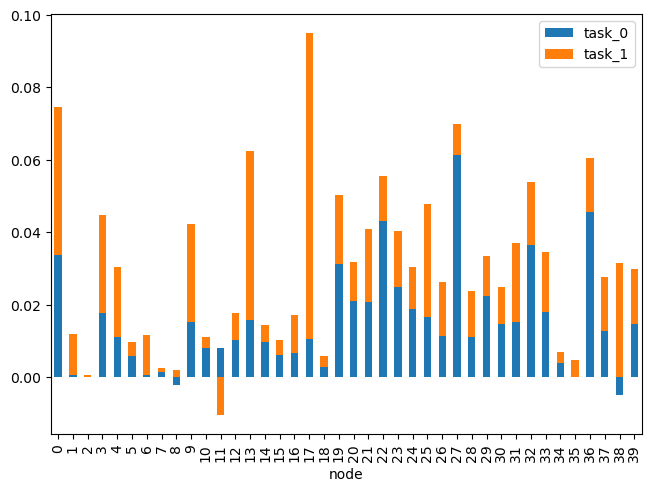

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
avg_shap_pd.plot(x="node", kind="bar", stacked=True, ax=ax)


In [ ]:
shapley_metric = np.array(
    [
        [
            avg_shap_pd[
                (i * n_hidden <= avg_shap_pd["node"])
                * (avg_shap_pd["node"] < (i + 1) * n_hidden)
            ][f"task_{t}"].mean()
            for t in range(2)
        ]
        for i in range(n_agents)
    ]
)
# shapley_metric = (shapley_metric - shapley_metric.min())
# shapley_metric /= np.linalg.norm(shapley_metric)

In [ ]:
shapley_metric


array([[0.00961133, 0.01583105],
       [0.02032031, 0.01497949]], dtype=float32)

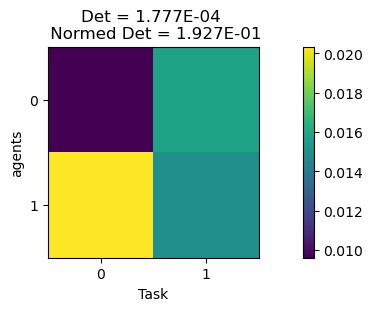

In [ ]:
plot_metric([shapley_metric])


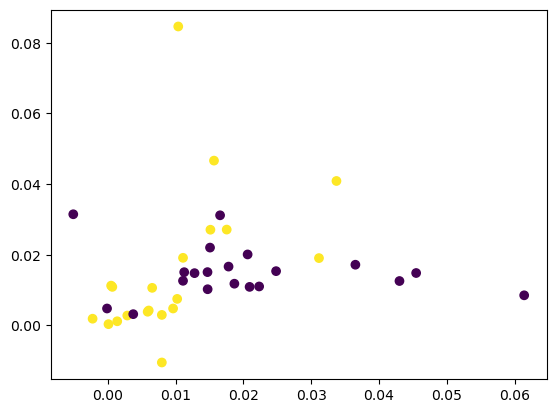

In [ ]:
plt.scatter(
    shapley_tables_avg[0],
    shapley_tables_avg[1],
    c=np.arange(shapley_tables_avg[0].shape[0]) < shapley_tables_avg[0].shape[0] // 2,
)


In [ ]:
km = KMeans(2)
all_shapley = pd.concat(shapley_tables_avg, axis=1)
km.fit(all_shapley)
kmeans_labels = km.labels_

plt.scatter(shapley_tables_avg[0], shapley_tables_avg[1], c=kmeans_labels)

NameError: name 'KMeans' is not defined

In [ ]:
shapley_table, contributions, lesion_effects = msa.interface(
    multiprocessing_method="joblib",
    elements=nodes,
    n_permutations=10,
    objective_function=masked_inference,
    n_parallel_games=24,
)

# Stability

In [ ]:
for ag in community.agents:
    eigens = torch.linalg.eigvals(ag.w_rec).cpu().data
    plt.figure()
    plt.scatter(eigens.real, eigens.imag)


In [ ]:
for state in states.transpose(0, 1).cpu():
    plt.figure()
    for s in state.transpose(0, -1):
        plt.plot(range(6), s.mean(0).cpu().data)


# New Data Gen

In [ ]:
labels, centers = datasets[0].data[1:]
centers = centers.transpose(0, 1)
symbols = datasets[0].symbols
symbol_size = datasets[0].symbol_size
centers.shape


In [ ]:
data_size = 10000
input_size = 60
n_steps = centers.shape[0]
n_symbols = centers.shape[-2]
symbol_assignments = [datasets[0].get_random_symbol_assignement(l) for l in labels]


In [ ]:
def fill_grid(idxs):
    # grids = np.zeros((n_steps, data_size, input_size, input_size))
    time_step, data_idx, symbol = idxs
    center_pos = centers[time_step, data_idx, symbol]
    label = symbol_assignments[data_idx][symbol]
    grids[
        time_step,
        data_idx,
        center_pos[0] : center_pos[0] + symbol_size,
        center_pos[1] : center_pos[1] + symbol_size,
    ] += symbols[label]
    # return grids


@ray.remote
def fill_grid_data(time_step):

    grids = np.zeros((data_size, input_size, input_size))
    for data_idx in range(data_size):
        for symbol in range(n_symbols):
            center_pos = centers[time_step, data_idx, symbol]
            label = symbol_assignments[data_idx][symbol]
            grids[
                data_idx,
                center_pos[0] : center_pos[0] + symbol_size,
                center_pos[1] : center_pos[1] + symbol_size,
            ] += symbols[label]

    return grids


def old_method():
    grids = []

    def assign_square(grid, center_pos, l, d):
        grid[
            d,
            center_pos[0] : center_pos[0] + symbol_size,
            center_pos[1] : center_pos[1] + symbol_size,
        ] += symbols[l]

    for center in centers:
        grid = np.zeros((data_size, input_size, input_size))
        for d in range(data_size):
            for i, c in enumerate(center[d]):
                # l = int(i < labels[d])
                assign_square(grid, (c[0], c[1]), symbol_assignments[d][i], d)

        grids.append(grid)

    grids = np.stack(grids)

    return grids


time_data_and_sym = [
    [t, d, i]
    for t in range(n_steps)
    for d in range(data_size)
    for i in range(n_symbols)
]


In [ ]:
import ray

num_cpus = 24

grids = np.zeros((n_steps, data_size, input_size, input_size))

grids_id = ray.put(grids)


prof = profile.Profile()
prof.enable()

grids = np.stack(ray.get([fill_grid_data.remote(idx) for idx in range(n_steps)]))
print(grids.shape)

prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows


In [ ]:
grids = np.zeros((n_steps, data_size, input_size, input_size))
vect_fill = np.vectorize(fill_grid, signature="(N)->()")

prof = profile.Profile()
prof.enable()

grids = vect_fill(time_data_and_sym)
print(grids.shape)

prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows


In [ ]:
grids = np.zeros((n_steps, data_size, input_size, input_size))

prof = profile.Profile()
prof.enable()

grids = [fill_grid(idx) for idx in time_data_and_sym]

prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows


In [ ]:
prof = profile.Profile()
prof.enable()

grids_old = old_method()
print(grids_old.shape)
prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows


In [ ]:
from joblib import delayed, Parallel


In [ ]:
prof = profile.Profile()
prof.enable()

grids = np.stack([fill_grid_data(d) for d in trange(n_steps)])
grids.shape

prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows


In [ ]:
prof = profile.Profile()
prof.enable()

grids = np.stack(
    Parallel(24, max_nbytes=1e12, backend="multiprocessing")(
        delayed(fill_grid_data)(idx) for idx in trange(n_steps)
    )
)

prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows
